In [172]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Exact diagonalization of the Spin-1/2 XXX 1D/2D model with PBC  in Sz=0 magnetization sector, exploiting momentum conservation 

## Exam of Computer simulation of condensed matter: from molecular dynamics to quantum Monte Carlo and Tensor Networks (prof. Collura part)

Fixing the number of lattice sites N and varying the aspect ratio (i.e. one chain, a ladder and a square), we have to study:

i) the energy level distribution

ii) the level spacing statistics

### 1D- Isotropic Heisenberg model:  $$H=J \sum_{i=0}^{N-1} \mathbf{S_i} \cdot \mathbf{S_{i+1}} = J \sum_{i=0}^{N-1} \Bigl[S_i^z S_{i+1}^z + \frac{1}{2} (S_i^+ S_{i+1}^-+S_i^- S_{i+1}^+)\Bigr]$$

(oss. $\mathbf{S}_N = \mathbf{S}_0$ because of PBC)

ED $\to$ **complete knowledge** of a quantum spin system 

but the study is limited to **small lattices**, because the Hilbert space increases exponentially with N

hence we have to exploit symmetries in order to reduce the **computational cost**

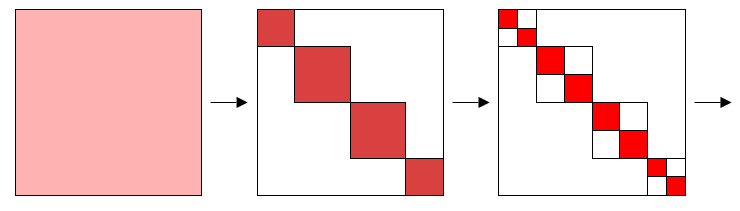

In [173]:
from IPython.display import Image
Image(filename='final/pic/block.png') 

*Schematic illustration of block diagonalization.* In the original basis, the Hamiltonian has
no apparent structure (sparse matrix to the left). By constructing states labeled by a conserved quantum number (the magnetization in our case), the matrix breaks up into blocks that can be diagonalized independently of each other (middle). Applying another symmetry (i.e. translational invariance), the blocks can be further broken up into smaller blocks (right) labeled by different quantum numbers, etc.

## The code

Here we follow the notes on *Computational Studies of Quantum Spin Systems* and the pseudocode given by prof. **Anders W. Sandvik**.

### Bit representation of the states

S=1/2 models: spins $\{ \downarrow, \uparrow\} \to$ bits $\{0,1\}$ of an integer

generic state $|S_0^z,S_1^z,\dots,S_{N-1}^z\rangle \to$ represented by a number from $0$ to $2^{N}-1$ (the size of the basis is $2^N$)

then with standard integers (4-byte) we can study systems up to 32 spins

### Computer generation of the Hamiltonian

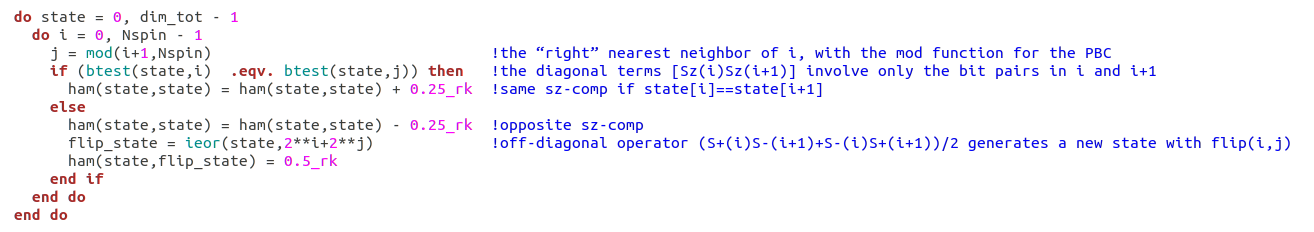

In [174]:
from IPython.display import Image
Image(filename='final/pic/tot_ham.png') 

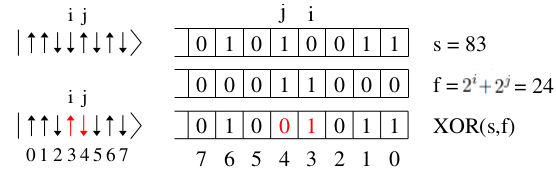

In [175]:
from IPython.display import Image
Image(filename='final/pic/flip.png') 

### Fixed-magnetization blocks

Exploiting the magnetization conservation, we want to construct the block hamiltonian acting on all the states with given $m_z = \sum_{i=0}^{N-1} S_i^z = (n_\uparrow - n_\downarrow)/2$. There are $M = N!/(n_\uparrow! n_\downarrow!)$ such states.

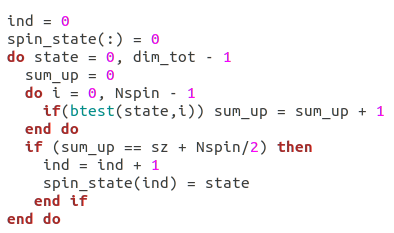

In [176]:
from IPython.display import Image
Image(filename='final/pic/magn_states.png') 

To construct the Hamiltonian, we loop over the labels $a = 1, \dots, M$ of the components of the each $m_z$ states vector and we proceed as before on the corresponding integers $s_a$ . When an off-diagonal operation on $|s_a \rangle$ leads to another state $|s_b \rangle$ we have to find the position $b$ of that integer in the list. Since it is ordered, we can do this by a bisectional search (in $ \simeq \log_2 (M)$ steps on average).

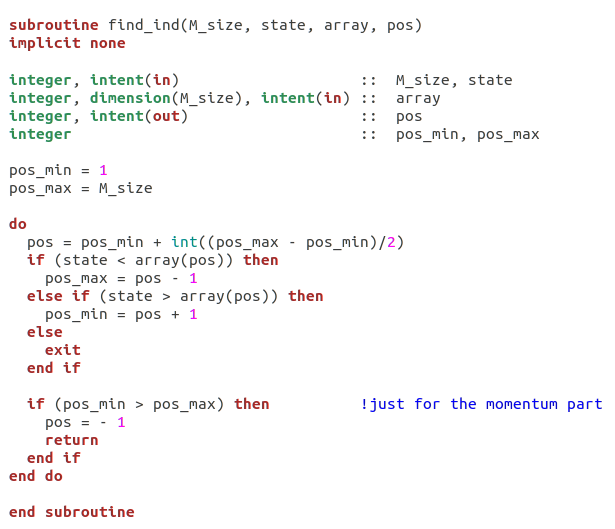

In [177]:
from IPython.display import Image
Image(filename='final/pic/find.png') 

### Fixed-momentum sub-blocks

For translationally invariant (periodic) systems, we use the momentum conservation to further block-diagonalize the fixed $m_z$ blocks. Here in particular we analyze the $mz=0$ sector, constructed on the states with $n_\uparrow = n_\downarrow$.

We define the translation operator
as moving the spins one step cyclically to the “right”:
$$T |S_0^z,S_1^z,\dots,S_{N-1}^z\rangle = |S_{N-1}^z,S_0^z,\dots,S_{N-2}^z\rangle $$
The Heisenberg Hamiltonian with periodic boundary conditions is invariant with
respect to translations, (i.e. [H,T] = 0). We can therefore construct
momentum states $|\psi(k)\rangle$, which by definition are eigenstates of the translation operator: $T |\psi(k)\rangle = e^{ik}|\psi(k)\rangle$. 

The allowed momenta are $k = \frac{2 \pi}{N} n $, with $n = 0,\dots, N −1$, following from the fact that $T^N = 1$ (oss. we consider the lattice constat = 1). States with different $k$ form their own individually diagonalizable blocks
of the Hamiltonian. 

***The momentum-state basis.***

A momentum state can be constructed using a reference state $| a \rangle$ and all its translations:
$$|a(k) \rangle = \frac{1}{\sqrt{N_a}} \sum_{r=0}^{N-1} e^{-ikr} \ T^r | a \rangle$$
To construct the momentum basis for given $k$, among all the states of the set of translated states $T^r | a \rangle$, only one should be used as a representative. It is practical to always choose the representative as the one for which the integer $a(r)$ is the smallest.

The periodicity of a state is defined as the smallest integer $R_a$ for which $T^{R_a}| a \rangle = | a \rangle$. Then, if $R_a \le N$, there will be multiple copies of the same state in the sum. 

An important aspect of the momentum basis is that the periodicity of the representative has to be compatible with the momentum in order for $|a(k) \rangle$ to be a viable state. In particular the sum of phase factors associated with the representative state  $|a \rangle$  in the sum is $F(k,R_a) = \sum_{n=0}^{N/R_a-1} e^{-iknR_a}$, and it does not vanish only if $k R_a$ is a multiple of $2 \pi$.

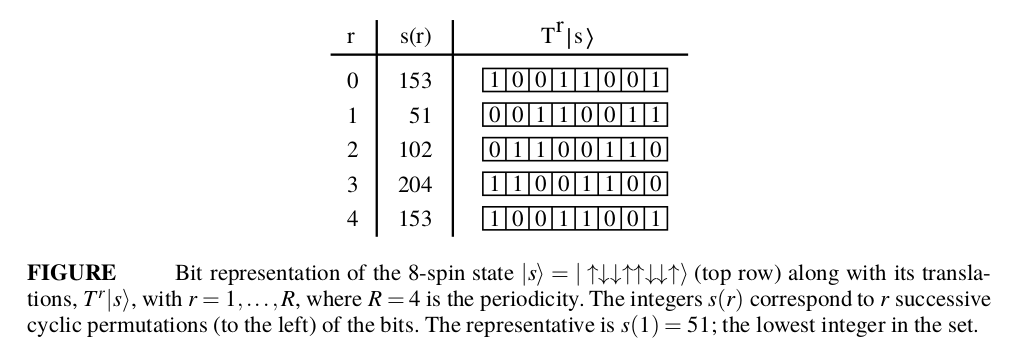

In [178]:
from IPython.display import Image
Image(filename='final/pic/per.png') 

***Constructing the momentum-state basis: the list of representatives.***

To generate the basis, we loop over the integers $s = 0, \dots , N!/(N/2!)^2$ and we determine whether a state is a valid new representative by performing bit operations.

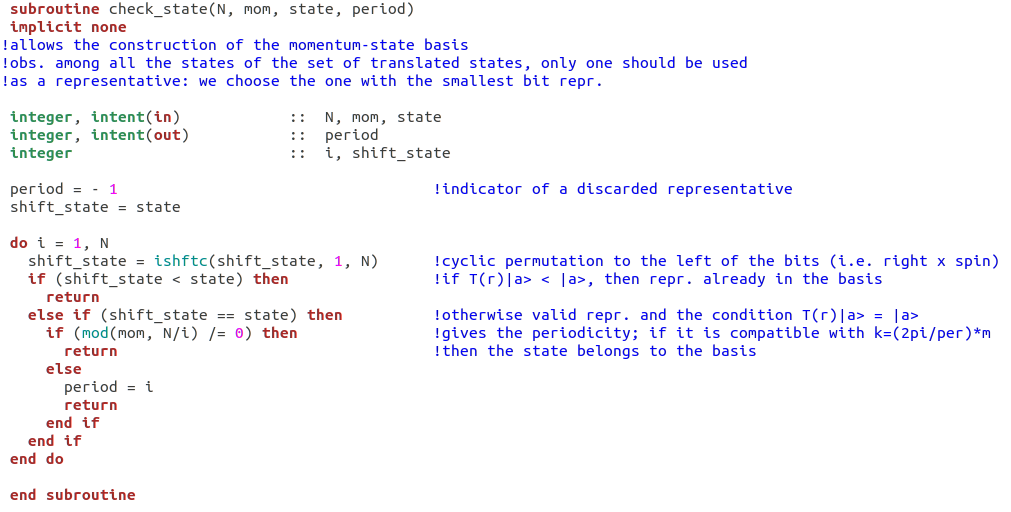

In [179]:
from IPython.display import Image
Image(filename='final/pic/check.png')

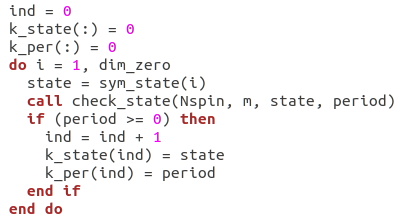

In [180]:
from IPython.display import Image
Image(filename='final/pic/basis.png')

***Constructing the $mz=0$ Hamiltonian k-blocks.***

To generate the k-blocks, we loop over the representatives. For each of them, we check the bits corresponding to all nearest-neighbor pairs $(i,j)$. The diagonal matrix element can be handled exactly as before. For the off-diagonal part, we need a few minor modifications. After two
spins have been flipped, the resulting state is typically not a representative. Then we need to find the corresponding one and to know the number of translations $l$ used to get it, since we need to implement:
$$H(a, b) = H(a,b) + \frac{1}{2} \sqrt{\frac{R_a}{R_b}} e^{i\frac{2 \pi n}{N} \ \ l}$$

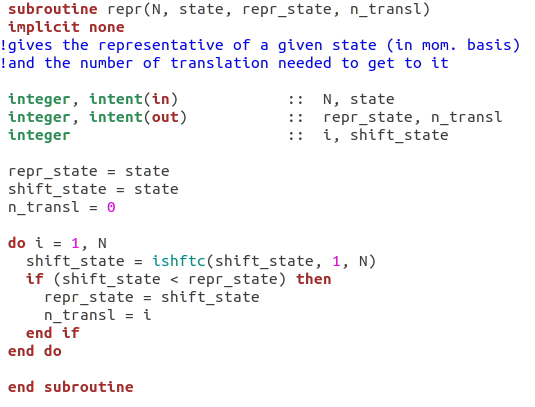

In [181]:
from IPython.display import Image
Image(filename='final/pic/repr.png')

In the end we can diagonalize each k-block with the Lapack subroutine for hermitian matrices *zheev*, we collect the energy levels (per particle) and we study the distribution and the spacing statistics via $r(j) = min[d(j),d(j-1)]/max[d(j),d(j-1)]$, with $d(j) = E(j+1)-E(j)$, after having ordered the spectrum in ascending order.

## 2D generalization

***Defining the lattice.***

x-coord.: $0, \dots, N_x-1$ and y-coord.: $0, \dots, N_y-1$ $\Longrightarrow$ lattice site index: $i = x + y \cdot N_x$ $\Longrightarrow$ bit repr. of the spin as before

we consider for each site the interaction with the NN on the right: $mod(x+1,N_x) + y \cdot N_x	$ and up: $x + mod(y+1,N_y)\cdot N_x$, in order to avoid double counting.

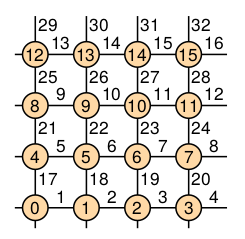

In [182]:
from IPython.display import Image
Image(filename='final/pic/bidim.png')

***Translations in 2 dimensions.***

$$T_{\alpha} |S_0^z,S_1^z,\dots,S_{N-1}^z\rangle = |S_{T_{\alpha}(0)}^z,S_{T_{\alpha}(1)}^z,\dots,S_{T_{\alpha}(N-1)}^z\rangle \quad \alpha = x,y$$ 

where the translated spin indices are:

$$T_x(i) = mod(x_i−1, N_x) + y_i \cdot N_x$$
$$T_y(i) = x_i + mod((y_i−1, N_y)N_x$$

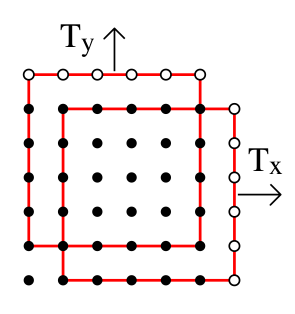

In [183]:
from IPython.display import Image
Image(filename='final/pic/transl.png')

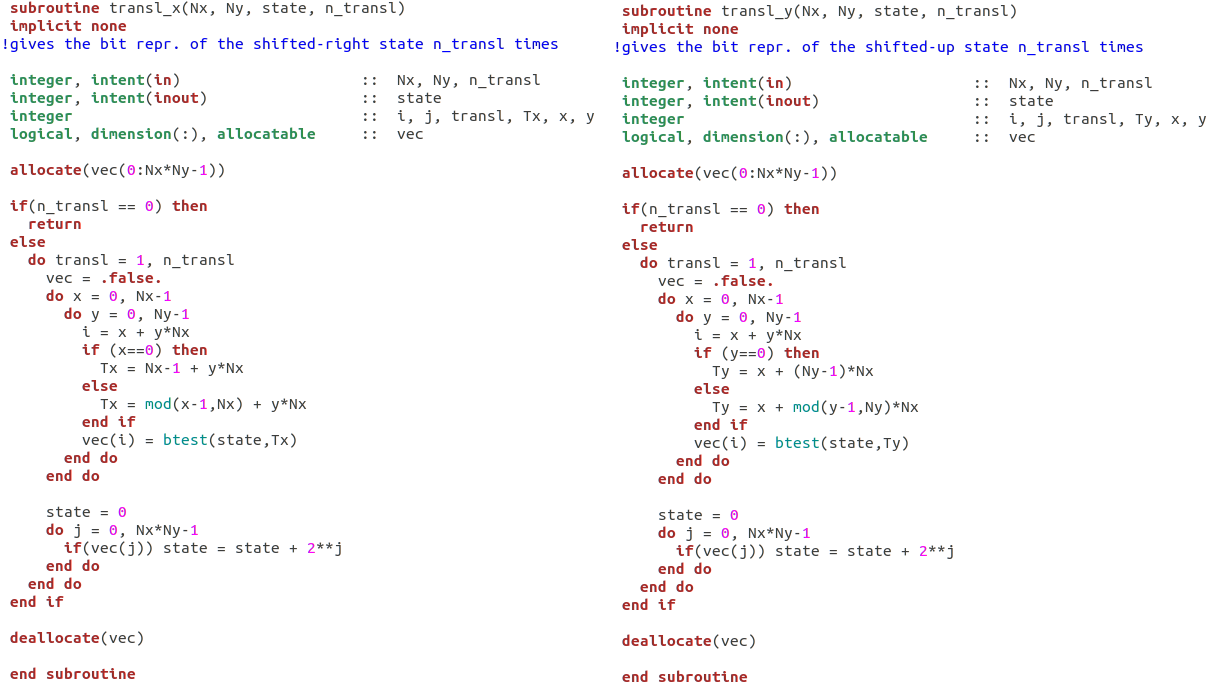

In [184]:
from IPython.display import Image
Image(filename='final/pic/transl_sub.png')

Using these translations, a momentum state based on a representative $|a\rangle$ is defined as:

$$|a(\mathbf{k}) \rangle = \frac{1}{\sqrt{N_a}} \sum_{x=0}^{N_x-1}\sum_{y=0}^{N_y-1} e^{-i(k_x x + k_y y)} \ \ T^x_x T^y_y | a \rangle$$

The normalization constant $N_a$ depends on the translational properties of the representive, i.e. the number of different states $D_a$ obtained among the group of $N_x\times N_y$ translations of the representative $|a \rangle$. A representative is incompatible with the momentum if the sum of phases $F_a$ over the translations bringing $|a \rangle$ onto itself vanishes. For a compatible state, the
normalization constant $N_a = D_a |F_a|^2 .

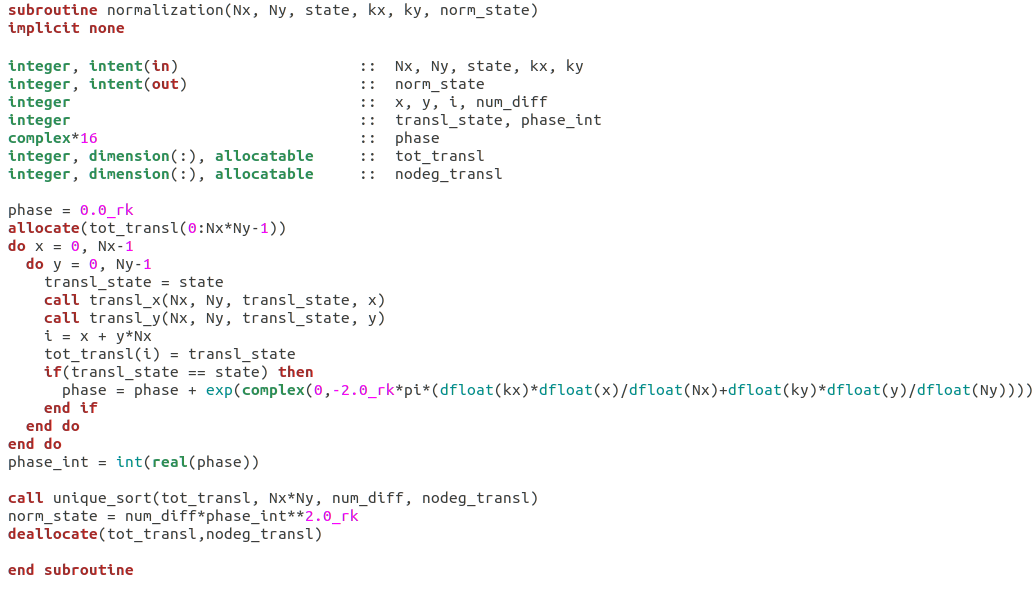

In [185]:
from IPython.display import Image
Image(filename='final/pic/norm.png')

1) we focus on the $12870$ states with $n_\uparrow = n_\downarrow$, with the spin labelled with the explained convention

2) we call the subroutine repr_list, creating a map between each state and its representative

3) we proceed as in 1D:

    a) we loop over the allowed momenta
    
    b) we store the compatible states by mean of normalization
    
    c) we loop over these states and for each one over the bit positions
    
    d) we construct the Hamiltonian k-blocks and we diagonalize them

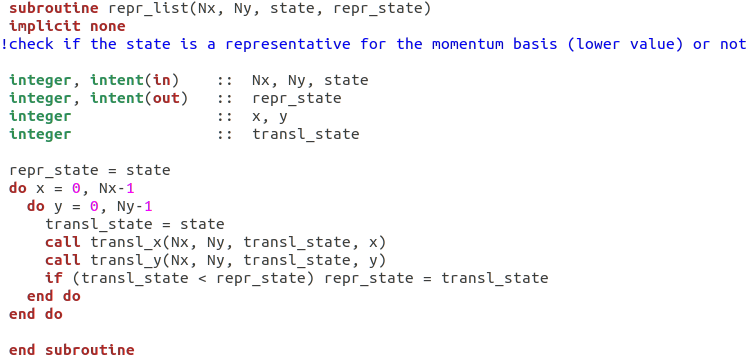

In [186]:
from IPython.display import Image
Image(filename='final/pic/repr_list.png')

For all the calculations we work with 𝑁=16

spins. This choice is based on two reasons:

1) diagonalizing the full 𝑚𝑧=0 requires some minutes with dsyev and this allows us a comparison between the results with and without the momentum conservation

2) the next even perfect square number is 36 and this implies that:

    a) we have to use 8-byte integers

    b) the allocation exceeds the memory unless we apply other symmetries such as the reflections 

## Results

In [187]:
da = pd.read_csv("prog/data/Sz=0_lev_chain.dat", header=None, delimiter=r"\s+")
db = pd.read_csv("prog/data/k-blocks_lev_chain.dat", header=None, delimiter=r"\s+")
dc = pd.read_csv("prog/data/Sz=0_lev_ladder.dat", header=None, delimiter=r"\s+")
dd = pd.read_csv("prog/data/k-blocks_lev_ladder.dat", header=None, delimiter=r"\s+")
de = pd.read_csv("prog/data/Sz=0_lev_square.dat", header=None, delimiter=r"\s+")
df = pd.read_csv("prog/data/k-blocks_lev_square.dat", header=None, delimiter=r"\s+")

dg = pd.read_csv("prog/data/r(j)_chain.dat", header=None, delimiter=r"\s+")
dh = pd.read_csv("prog/data/r(j)_ladder.dat", header=None, delimiter=r"\s+")
di = pd.read_csv("prog/data/r(j)_square.dat", header=None, delimiter=r"\s+")

In [188]:
xa = da[0]
xb = db[0]
xc = dc[0]
xd = dd[0]
xe = de[0]
xf = df[0]

xg = dg[0]
xh = dh[0]
xi = di[0]
x = np.linspace(0, 1, 1000)
y = 2/(1+x)**2

### CHAIN CONFIGURATION (16x1)

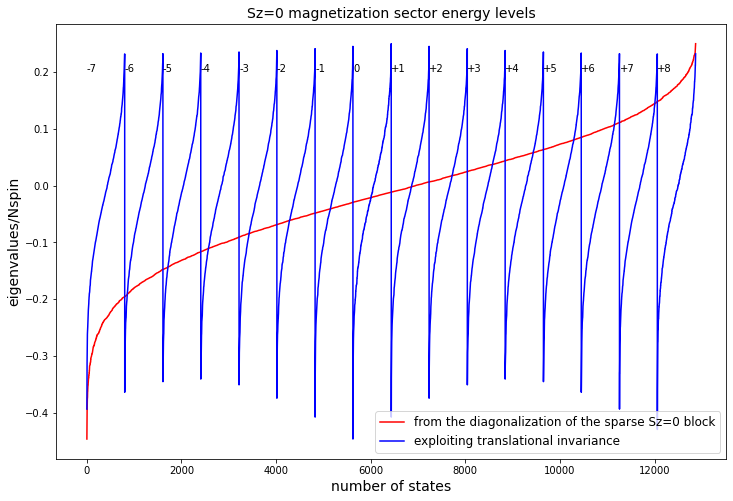

In [189]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
plt.plot(xa, color = "red", label='from the diagonalization of the sparse Sz=0 block')
plt.plot(xb, color = "blue", label='exploiting translational invariance')
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)

plt.text(0,0.2,'-7'); plt.text(800,0.2,'-6'); plt.text(1608,0.2,'-5'); plt.text(2408,0.2,'-4')
plt.text(3217,0.2,'-3'); plt.text(4017,0.2,'-2'); plt.text(4825,0.2,'-1'); plt.text(5625,0.2,'0')
plt.text(6435,0.2,'+1'); plt.text(7235,0.2,'+2'); plt.text(8043,0.2,'+3'); plt.text(8843,0.2,'+4')
plt.text(9652,0.2,'+5'); plt.text(10452,0.2,'+6'); plt.text(11260,0.2,'+7'); plt.text(12060,0.2,'+8')

ax.set_title("Sz=0 magnetization sector energy levels", fontsize=14)
ax.legend(loc='lower right', fontsize = 'large')      
plt.show()

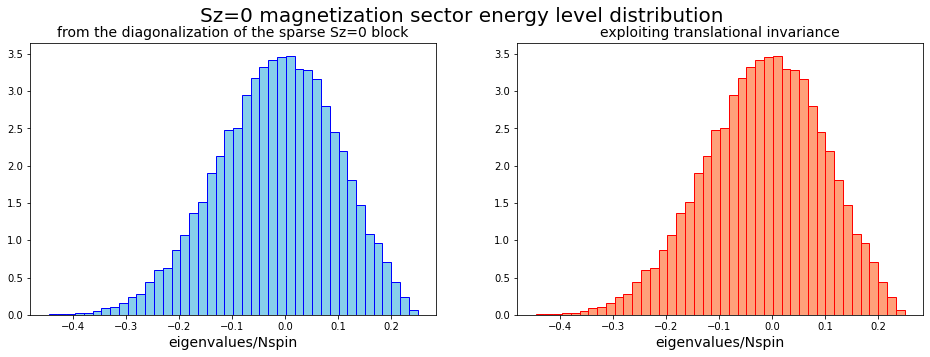

In [190]:
fig = plt.figure(figsize=(16,5))
fig.suptitle('Sz=0 magnetization sector energy level distribution', fontsize=20) 

ax = fig.add_subplot(121)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xa, bins=42, density=True, color = "skyblue", ec="blue")
ax.set_title("from the diagonalization of the sparse Sz=0 block", fontsize=14)


ax = fig.add_subplot(122)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xb, bins=42, density=True, color = "lightsalmon", ec="red")
ax.set_title("exploiting translational invariance", fontsize=14)

plt.show()

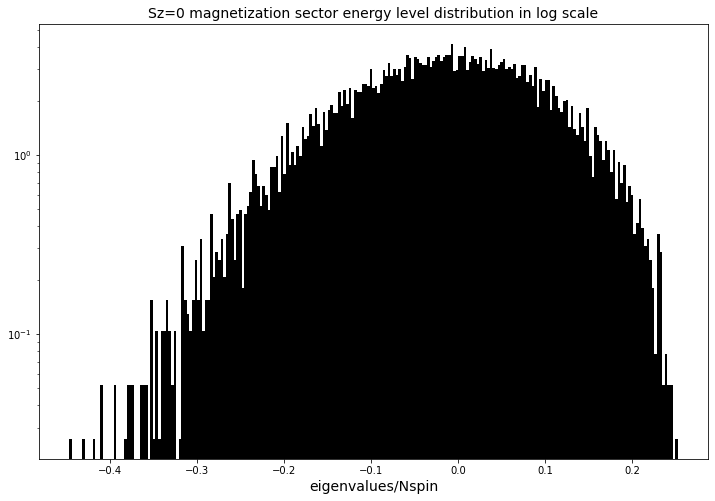

In [191]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
bins1 = np.arange(xa.min(), xa.max()+0.003, 0.003)
plt.hist(xa, bins=bins1, density=True, color = "black")

ax.set_title("Sz=0 magnetization sector energy level distribution in log scale", fontsize=14)

ax.set_yscale('log')

plt.show()


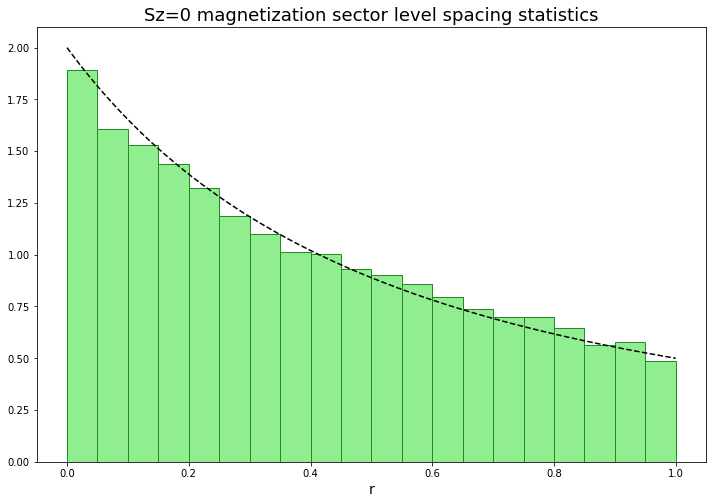

In [192]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)
plt.hist(xg, bins=20, density=True, color = "lightgreen", ec="forestgreen")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Sz=0 magnetization sector level spacing statistics", fontsize=18)

plt.show()

### LADDER CONFIGURATION (8x2)

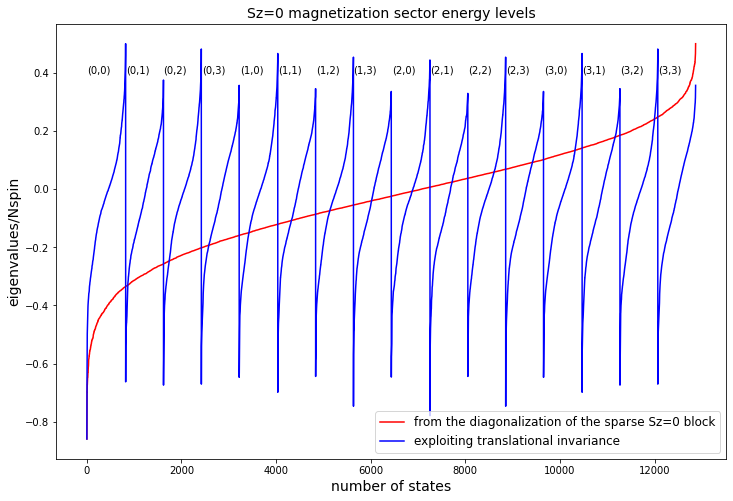

In [193]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
plt.plot(xc, color = "red", label='from the diagonalization of the sparse Sz=0 block')
plt.plot(xd, color = "blue", label='exploiting translational invariance')
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)

plt.text(0,0.4,'(0,0)'); plt.text(822,0.4,'(0,1)'); plt.text(1622,0.4,'(0,2)'); plt.text(2438,0.4,'(0,3)')
plt.text(3238,0.4,'(1,0)'); plt.text(4038,0.4,'(1,1)'); plt.text(4838,0.4,'(1,2)'); plt.text(5638,0.4,'(1,3)')
plt.text(6454,0.4,'(2,0)'); plt.text(7254,0.4,'(2,1)'); plt.text(8070,0.4,'(2,2)'); plt.text(8870,0.4,'(2,3)')
plt.text(9670,0.4,'(3,0)'); plt.text(10470,0.4,'(3,1)'); plt.text(11270,0.4,'(3,2)'); plt.text(12070,0.4,'(3,3)')
ax.legend(loc='lower right', fontsize = 'large')

ax.set_title("Sz=0 magnetization sector energy levels", fontsize=14)
plt.show()

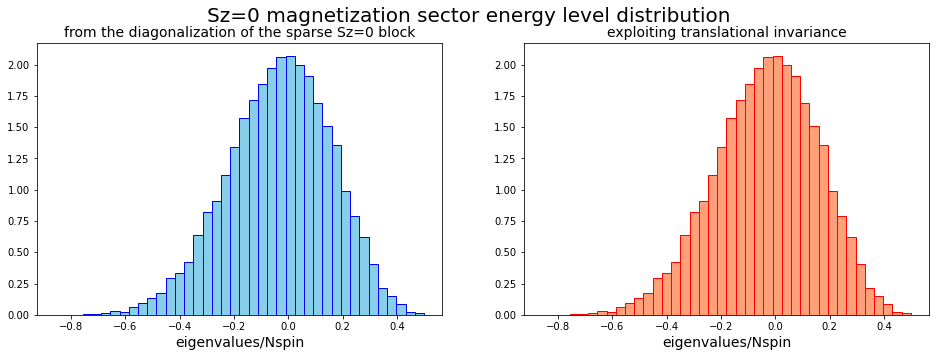

In [194]:
fig = plt.figure(figsize=(16,5))
fig.suptitle('Sz=0 magnetization sector energy level distribution', fontsize=20) 

ax = fig.add_subplot(121)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xc, bins=40, density=True, color = "skyblue", ec="blue")
ax.set_title("from the diagonalization of the sparse Sz=0 block", fontsize=14)


ax = fig.add_subplot(122)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xd, bins=40, density=True, color = "lightsalmon", ec="red")
ax.set_title("exploiting translational invariance", fontsize=14)

plt.show()

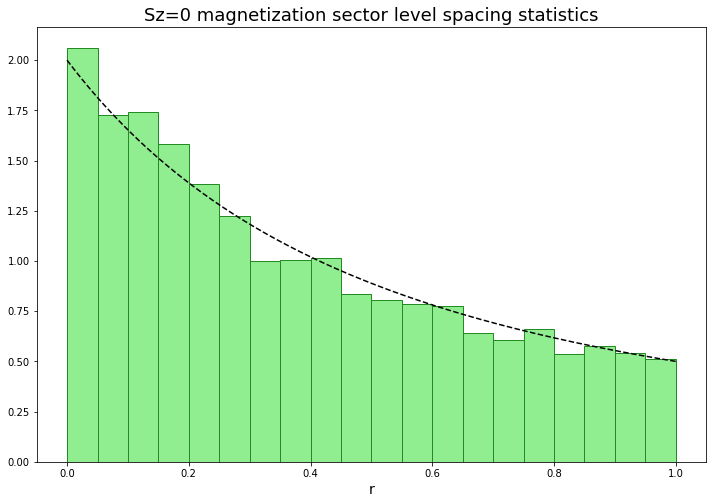

In [195]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)
plt.hist(xh, bins=20, density=True, color = "lightgreen", ec="forestgreen")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Sz=0 magnetization sector level spacing statistics", fontsize=18)

plt.show()

### SQUARE CONFIGURATION (4x4)

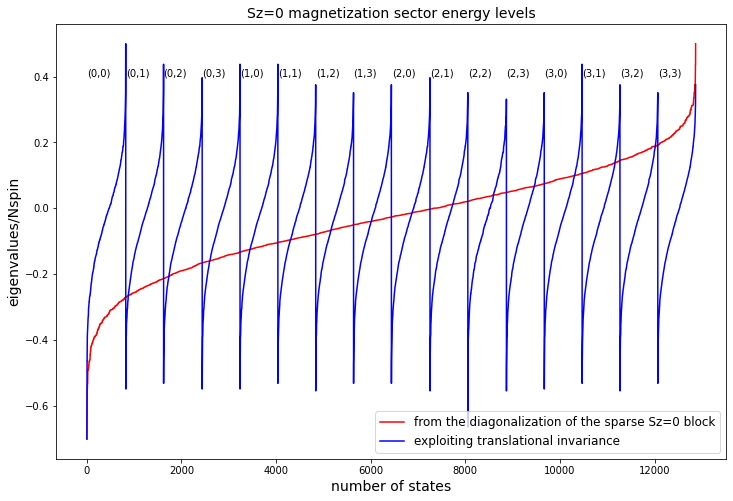

In [196]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
plt.plot(xe, color = "red", label='from the diagonalization of the sparse Sz=0 block')
plt.plot(xf, color = "blue", label='exploiting translational invariance')
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)

plt.text(0,0.4,'(0,0)'); plt.text(822,0.4,'(0,1)'); plt.text(1622,0.4,'(0,2)'); plt.text(2438,0.4,'(0,3)')
plt.text(3238,0.4,'(1,0)'); plt.text(4038,0.4,'(1,1)'); plt.text(4838,0.4,'(1,2)'); plt.text(5638,0.4,'(1,3)')
plt.text(6454,0.4,'(2,0)'); plt.text(7254,0.4,'(2,1)'); plt.text(8070,0.4,'(2,2)'); plt.text(8870,0.4,'(2,3)')
plt.text(9670,0.4,'(3,0)'); plt.text(10470,0.4,'(3,1)'); plt.text(11270,0.4,'(3,2)'); plt.text(12070,0.4,'(3,3)')

ax.set_title("Sz=0 magnetization sector energy levels", fontsize=14)
ax.legend(loc='lower right', fontsize = 'large')
plt.show()

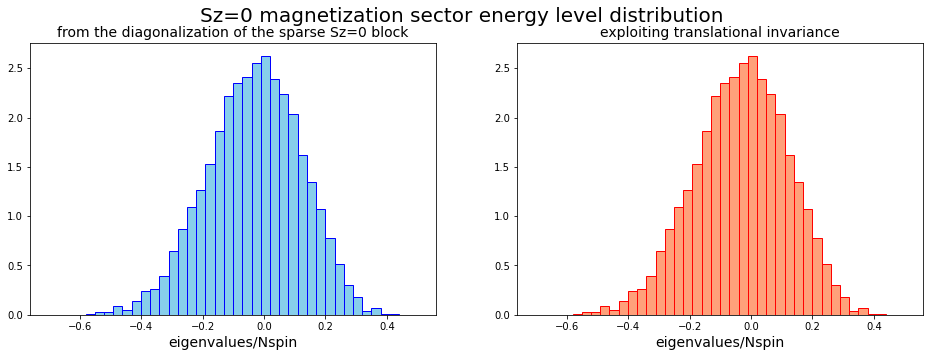

In [197]:
fig = plt.figure(figsize=(16,5))
fig.suptitle('Sz=0 magnetization sector energy level distribution', fontsize=20) 

ax = fig.add_subplot(121)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xe, bins=40, density=True, color = "skyblue", ec="blue")
ax.set_title("from the diagonalization of the sparse Sz=0 block", fontsize=14)


ax = fig.add_subplot(122)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xf, bins=40, density=True, color = "lightsalmon", ec="red")
ax.set_title("exploiting translational invariance", fontsize=14)

plt.show()

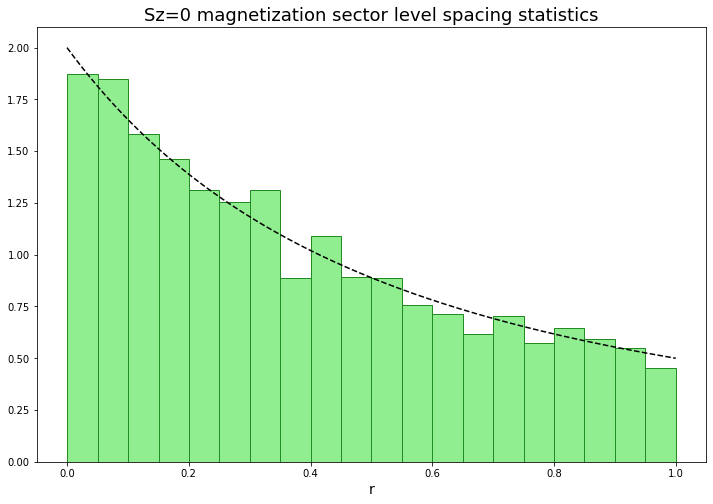

In [198]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)
plt.hist(xi, bins=20, density=True, color = "lightgreen", ec="forestgreen")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Sz=0 magnetization sector level spacing statistics", fontsize=18)

plt.show()

### COMPARISON

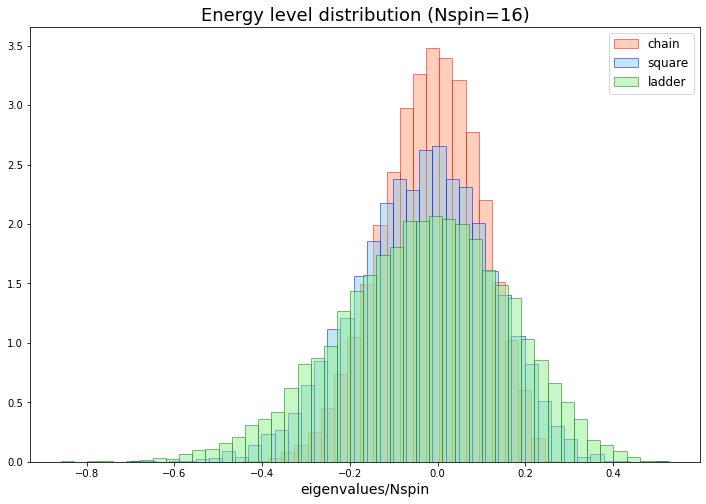

In [199]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('eigenvalues/Nspin', fontsize=14)

bins1 = np.arange(xa.min(), xa.max()+0.03, 0.03)
bins2 = np.arange(xc.min(), xc.max()+0.03, 0.03)
bins3 = np.arange(xe.min(), xe.max()+0.03, 0.03)

plt.hist(xa, bins=bins1, density=True, color = "lightsalmon", ec="red", alpha=0.5, label='chain')
plt.hist(xe, bins=bins3, density=True, color = "skyblue", ec="blue", alpha=0.5, label='square')
plt.hist(xc, bins=bins2, density=True, color = "lightgreen", ec="green", alpha=0.5, label='ladder')

ax.set_title("Energy level distribution (Nspin=16)", fontsize=18)
ax.legend(loc='upper right', fontsize = 'large')
plt.show()

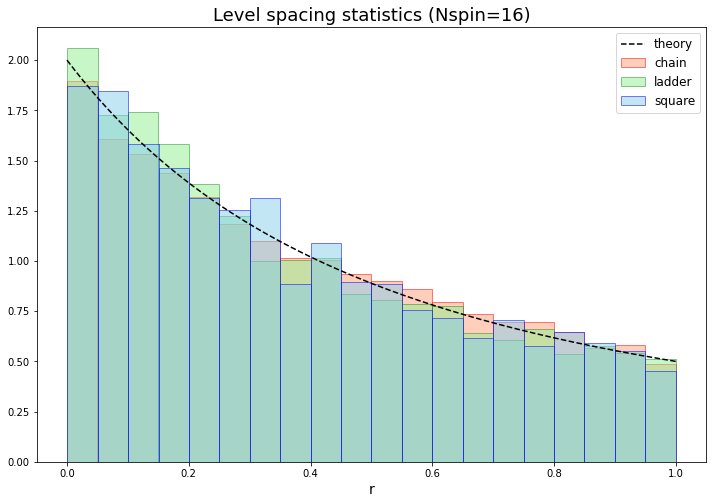

In [200]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)

plt.hist(xg, bins=20, density=True, color = "lightsalmon", ec="red", alpha=0.5, label='chain')
plt.hist(xh, bins=20, density=True, color = "lightgreen", ec="forestgreen", alpha=0.5, label='ladder')
plt.hist(xi, bins=20, density=True, color = "skyblue", ec="blue", alpha=0.5, label='square')

plt.plot(x, y, color = "black", ls='dashed', label='theory')

ax.set_title("Level spacing statistics (Nspin=16)", fontsize=18)
ax.legend(loc='upper right', fontsize = 'large')
plt.show()

### CHECK OF CONSISTENCY INCREASING N 

In [201]:
dl = pd.read_csv("prog/data/k-blocks_lev_chain18.dat", header=None, delimiter=r"\s+")
dm = pd.read_csv("prog/data/k-blocks_lev_chain20.dat", header=None, delimiter=r"\s+")
dn = pd.read_csv("prog/data/k-blocks_lev_ladder18.dat", header=None, delimiter=r"\s+")
do = pd.read_csv("prog/data/k-blocks_lev_ladder20.dat", header=None, delimiter=r"\s+")

dp = pd.read_csv("prog/data/r(j)_chain18.dat", header=None, delimiter=r"\s+")
dq = pd.read_csv("prog/data/r(j)_chain20.dat", header=None, delimiter=r"\s+")
dr = pd.read_csv("prog/data/r(j)_ladder18.dat", header=None, delimiter=r"\s+")
ds = pd.read_csv("prog/data/r(j)_ladder20.dat", header=None, delimiter=r"\s+")

In [202]:
xl = dl[0]
xm = dm[0]
xn = dn[0]
xo = do[0]

xl2 = np.sort(xl)
xm2 = np.sort(xm)
xn2 = np.sort(xn)
xo2 = np.sort(xo)

xp = dp[0]
xq = dq[0]
xr = dr[0]
xs = ds[0]

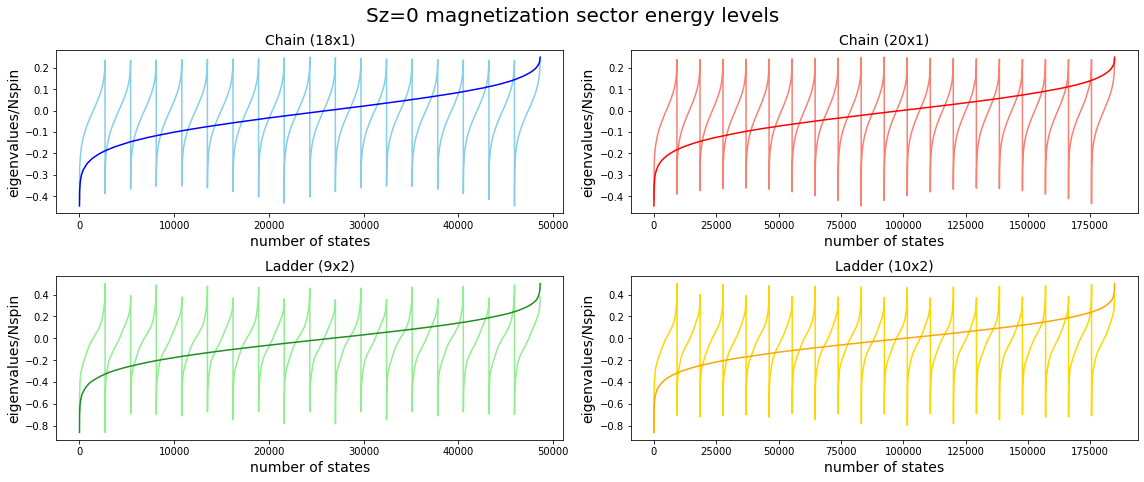

In [203]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(221)
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)
plt.plot(xl, color = "skyblue")
plt.plot(xl2, color = "blue")
ax.set_title("Chain (18x1)", fontsize=14)
fig.suptitle('Sz=0 magnetization sector energy levels', fontsize=20) 


ax = fig.add_subplot(222)
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)
plt.plot(xm, color = "salmon")
plt.plot(xm2, color = "red")
ax.set_title("Chain (20x1)", fontsize=14)

ax = fig.add_subplot(223)
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)
plt.plot(xn, color = "lightgreen")
plt.plot(xn2, color = "forestgreen")
ax.set_title("Ladder (9x2)", fontsize=14)


ax = fig.add_subplot(224)
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)
plt.plot(xo, color = "gold")
plt.plot(xo2, color = "orange")
ax.set_title("Ladder (10x2)", fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

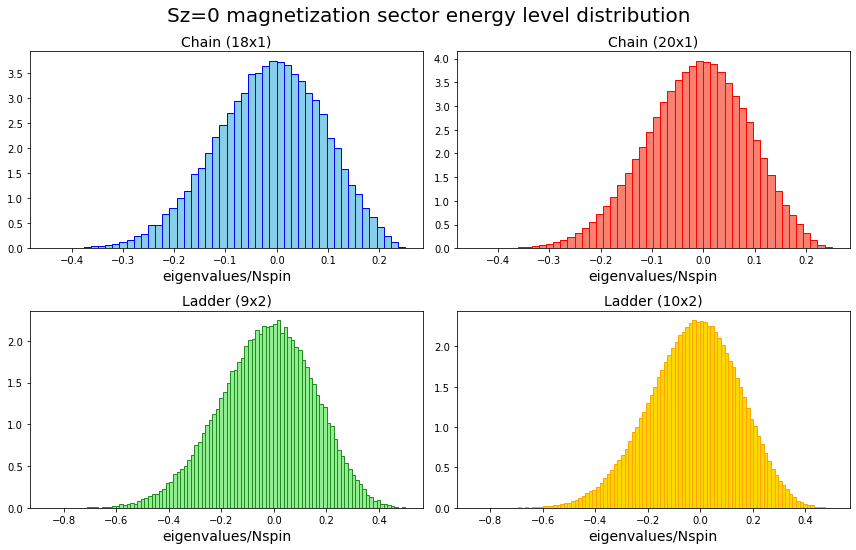

In [204]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Sz=0 magnetization sector energy level distribution', fontsize=20) 

ax = fig.add_subplot(221)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xl, bins=50, density=True, color = "skyblue", ec="blue")
ax.set_title("Chain (18x1)", fontsize=14)


ax = fig.add_subplot(222)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xm, bins=50, density=True, color = "salmon", ec="red")
ax.set_title("Chain (20x1)", fontsize=14)

ax = fig.add_subplot(223)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xn, bins=100, density=True, color = "lightgreen", ec="forestgreen")
ax.set_title("Ladder (9x2)", fontsize=14)


ax = fig.add_subplot(224)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xo, bins=100, density=True, color = "gold", ec="orange")
ax.set_title("Ladder (10x2)", fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

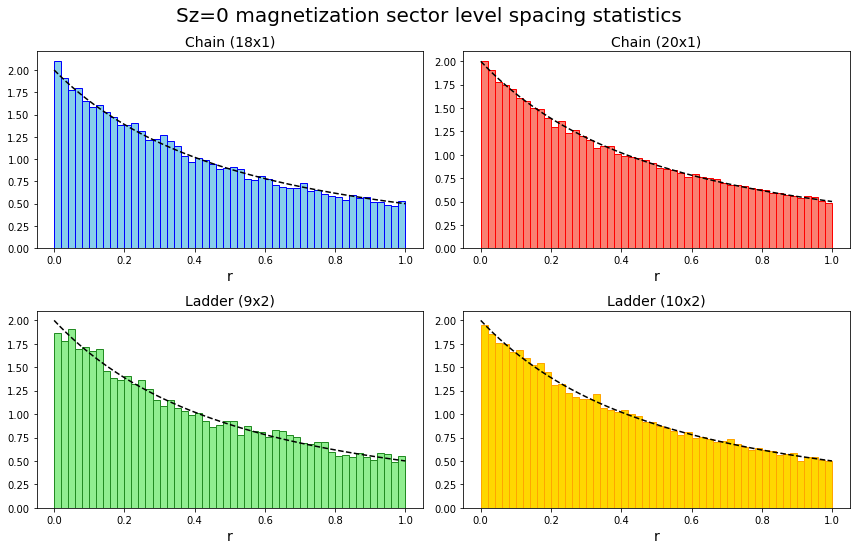

In [205]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Sz=0 magnetization sector level spacing statistics', fontsize=20) 

ax = fig.add_subplot(221)
plt.xlabel('r', fontsize=14)
plt.hist(xp, bins=50, density=True, color = "skyblue", ec="blue")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Chain (18x1)", fontsize=14)


ax = fig.add_subplot(222)
plt.xlabel('r', fontsize=14)
plt.hist(xq, bins=50, density=True, color = "salmon", ec="red")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Chain (20x1)", fontsize=14)

ax = fig.add_subplot(223)
plt.xlabel('r', fontsize=14)
plt.hist(xr, bins=50, density=True, color = "lightgreen", ec="forestgreen")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Ladder (9x2)", fontsize=14)


ax = fig.add_subplot(224)
plt.xlabel('r', fontsize=14)
plt.hist(xs, bins=50, density=True, color = "gold", ec="orange")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Ladder (10x2)", fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### COMPLETE SPECTRUM FOR THE CHAIN

In [221]:
dt = pd.read_csv("prog/complete/tot_levels.dat", header=None, delimiter=r"\s+")
du = pd.read_csv("prog/complete/r(j)_list.dat", header=None, delimiter=r"\s+")

In [222]:
xt = dt[0]
xu = du[0]

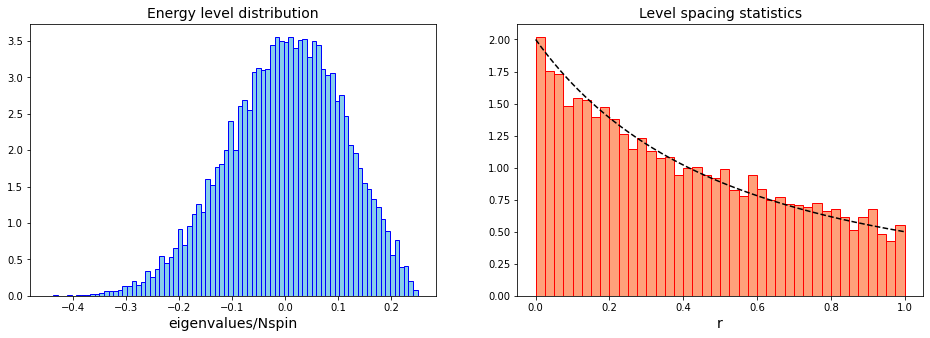

In [223]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(121)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xt, bins=80, density=True, color = "skyblue", ec="blue")
ax.set_title("Energy level distribution", fontsize=14)


ax = fig.add_subplot(122)
plt.xlabel('r', fontsize=14)
plt.hist(xu, bins=40, density=True, color = "lightsalmon", ec="red")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Level spacing statistics", fontsize=14)

plt.show()

### LADDER WITH THE SHORT DIRECTION IN OBC

In [270]:
dv = pd.read_csv("final/bidim/ladder/Sz=0_k-blocks_levels.dat", header=None, delimiter=r"\s+")
dz = pd.read_csv("final/bidim/ladder/check_Sz=0_levels.dat", header=None, delimiter=r"\s+")
dw = pd.read_csv("final/bidim/ladder/r(j)_list.dat", header=None, delimiter=r"\s+")

In [271]:
xv = dv[0]
xz = dz[0]
xw = dw[0]

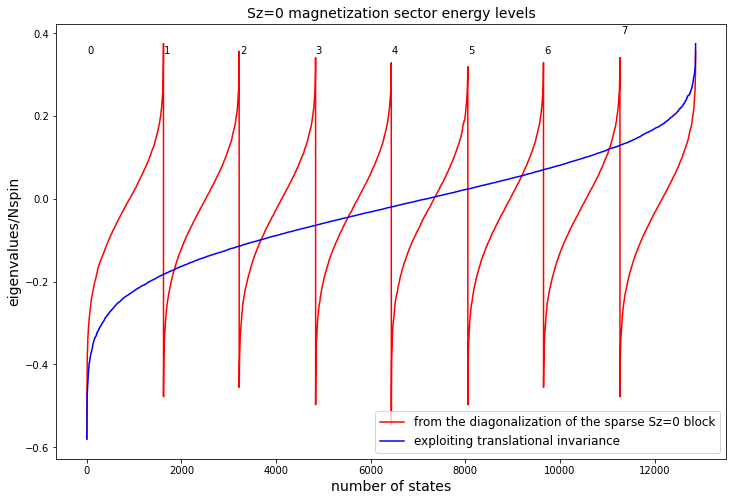

In [269]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
plt.plot(xv, color = "red", label='from the diagonalization of the sparse Sz=0 block')
plt.plot(xz, color = "blue", label='exploiting translational invariance')
plt.xlabel('number of states', fontsize=14)
plt.ylabel('eigenvalues/Nspin', fontsize=14)

plt.text(0,0.35,'0'); plt.text(1627,0.35,'1'); plt.text(3235,0.35,'2'); plt.text(4835,0.35,'3')
plt.text(6435,0.35,'4'); plt.text(8065,0.35,'5'); plt.text(9665,0.35,'6'); plt.text(11290,0.4,'7')

ax.set_title("Sz=0 magnetization sector energy levels", fontsize=14)
ax.legend(loc='lower right', fontsize = 'large')
plt.show()

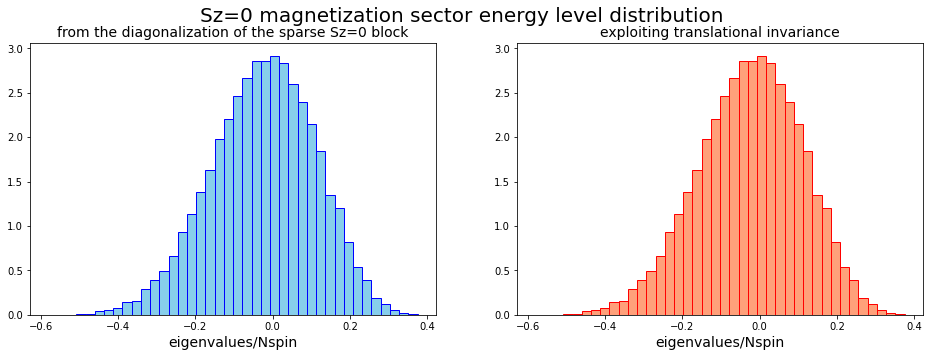

In [265]:
fig = plt.figure(figsize=(16,5))
fig.suptitle('Sz=0 magnetization sector energy level distribution', fontsize=20) 

ax = fig.add_subplot(121)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xv, bins=40, density=True, color = "skyblue", ec="blue")
ax.set_title("from the diagonalization of the sparse Sz=0 block", fontsize=14)


ax = fig.add_subplot(122)
plt.xlabel('eigenvalues/Nspin', fontsize=14)
plt.hist(xz, bins=40, density=True, color = "lightsalmon", ec="red")
ax.set_title("exploiting translational invariance", fontsize=14)

plt.show()

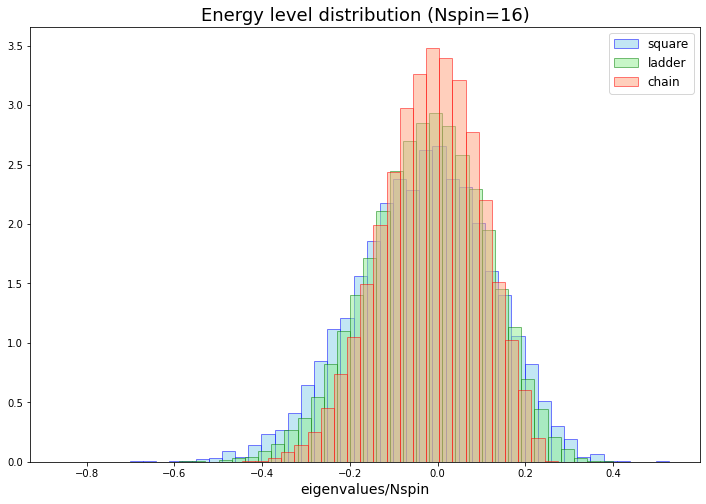

In [274]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('eigenvalues/Nspin', fontsize=14)

bins1 = np.arange(xa.min(), xa.max()+0.03, 0.03)
bins2 = np.arange(xc.min(), xc.max()+0.03, 0.03)
bins3 = np.arange(xe.min(), xe.max()+0.03, 0.03)

plt.hist(xe, bins=bins3, density=True, color = "skyblue", ec="blue", alpha=0.5, label='square')
plt.hist(xv, bins=bins2, density=True, color = "lightgreen", ec="green", alpha=0.5, label='ladder')
plt.hist(xa, bins=bins1, density=True, color = "lightsalmon", ec="red", alpha=0.5, label='chain')

ax.set_title("Energy level distribution (Nspin=16)", fontsize=18)
ax.legend(loc='upper right', fontsize = 'large')
plt.show()

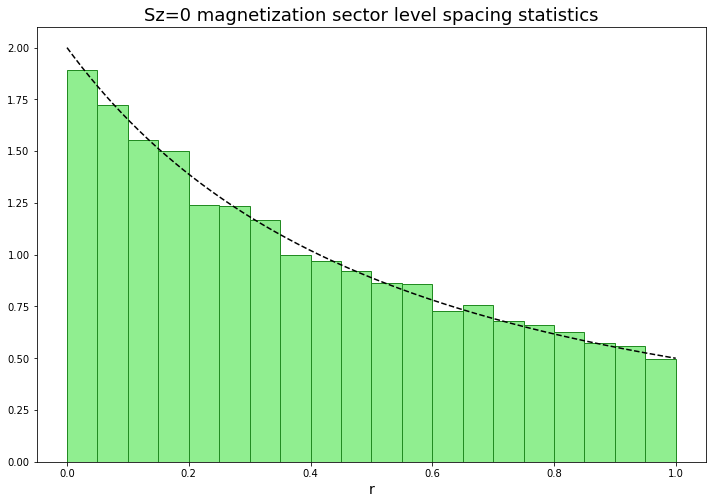

In [275]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)
plt.hist(xw, bins=20, density=True, color = "lightgreen", ec="forestgreen")
plt.plot(x, y, color = "black", ls='dashed')
ax.set_title("Sz=0 magnetization sector level spacing statistics", fontsize=18)

plt.show()

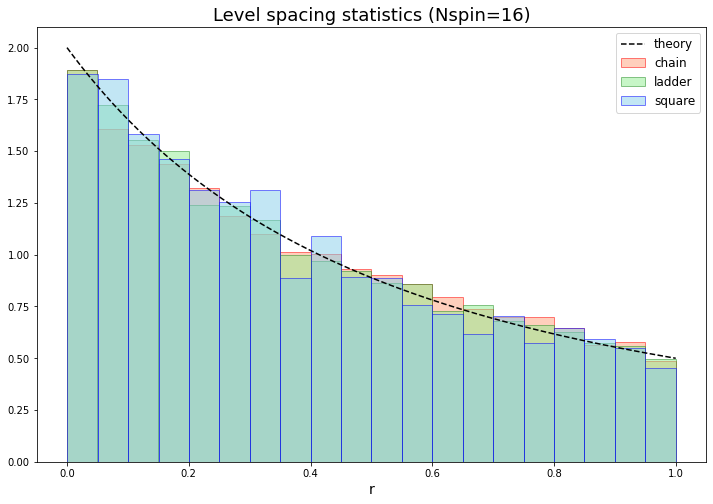

In [276]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.xlabel('r', fontsize=14)

plt.hist(xg, bins=20, density=True, color = "lightsalmon", ec="red", alpha=0.5, label='chain')
plt.hist(xw, bins=20, density=True, color = "lightgreen", ec="forestgreen", alpha=0.5, label='ladder')
plt.hist(xi, bins=20, density=True, color = "skyblue", ec="blue", alpha=0.5, label='square')

plt.plot(x, y, color = "black", ls='dashed', label='theory')

ax.set_title("Level spacing statistics (Nspin=16)", fontsize=18)
ax.legend(loc='upper right', fontsize = 'large')
plt.show()